## Installing Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [4]:
# Create dataframe
df2018flights = pd.read_csv("./Datasets1/2018.csv")

# Remove op_carrier_fl_num, crs_dep_time, dep_time, wheels_off, wheels_on, cancelled, cancellation_co..., diverted, actual_elapsed_..., air_time, unnamed:27
df2018flights = df2018flights.drop(["OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME", "WHEELS_OFF", "WHEELS_ON", "CANCELLED", "CANCELLATION_CODE", "DIVERTED", "ACTUAL_ELAPSED_TIME", "AIR_TIME", "Unnamed: 27"], axis= 1)

# Create month column
df2018flights["Month"] = pd.DatetimeIndex(df2018flights["FL_DATE"]).month

# Remove date column
df2018flights = df2018flights.drop(["FL_DATE"], axis= 1)

# Add labeled column
df2018flights["Label"] = np.where(df2018flights["ARR_DELAY"] > 0, 1, 0)

# Remove column use to make label
df2018flights = df2018flights.drop(["ARR_DELAY"], axis= 1)

# Dummy encode carrier, destination, and origin columns
df2018flights = pd.get_dummies(df2018flights, columns= ["OP_CARRIER", "ORIGIN", "DEST"])

df2018flights.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,...,DEST_USA,DEST_VEL,DEST_VLD,DEST_VPS,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YNG,DEST_YUM
0,-5.0,15.0,10.0,1745,1722.0,268.0,1605.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,7.0,1254,1230.0,99.0,414.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,5.0,1649,1636.0,134.0,846.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,6.0,1756,1754.0,190.0,1120.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,20.0,13.0,10.0,922,936.0,112.0,723.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Preparing and creating test train split
X = df2018flights.drop(["Label"], axis= 1)
y = df2018flights["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

## Catboost w/o Probabilities
This section demonstrates the accuracy at which the model can predict a flight being delayed when given binary (delayed or not) values

** Need to do some tuning on the model still **

Confusion matrix:
[[1101543   72849]
 [  55369  573601]]


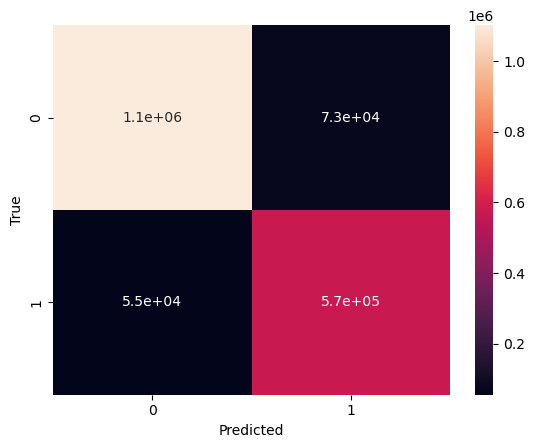

Accuracy: 0.9289005757024934
Precision: 0.8873091499729291
Recall: 0.9119687743453583
F1 Score: 0.8994699785168807


In [6]:
## 😸boost ##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict on test set
y_pred = cb.predict(X_test)

# evaluate model performance
conf_mat = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion matrix:")
print(conf_mat)
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

## Catboost with Probabilities
This section gathers the probability at which a flight will be delayed rather than giving it a binary value

** Using the same model as above **

In [7]:
## 😸boost w/o Probabilities##

# Calculate balance of class weights
import sklearn
weights = sklearn.utils.class_weight.compute_class_weight(class_weight= 'balanced', classes= np.unique(y), y= y)

cb = CatBoostClassifier(iterations=100, random_seed=0, logging_level='Silent', class_weights= weights)
cb.fit(X_train, y_train)

# predict probabilities on test set
y_predProba = cb.predict_proba(X_test)[::,1]

print(y_predProba)

[0.0579111  0.10013825 0.12116473 ... 0.67311618 0.00105431 0.01207546]


## Developing New Flight Dataframe w/ Carrier, Origin, Destination, and ProbabilityDelayed

In [8]:
dfXtest = pd.DataFrame(X_test)
dfXtest.head()

,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,...,DEST_USA,DEST_VEL,DEST_VLD,DEST_VPS,DEST_WRG,DEST_WYS,DEST_XNA,DEST_YAK,DEST_YNG,DEST_YUM
3679391,-4.0,12.0,5.0,1307,1302.0,107.0,600.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1654376,-1.0,12.0,4.0,1345,1339.0,70.0,327.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4411198,-5.0,23.0,4.0,1600,1554.0,105.0,532.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6534946,-7.0,14.0,3.0,509,446.0,289.0,2338.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
684521,-8.0,14.0,3.0,1638,1630.0,116.0,626.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Function to pull the locations (origin and destination) from X_test
def pullLocation(df, locType):
    newDict = {}

    df = df.filter(regex= locType).head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[1]

    return newDict

# Function to pull the carrier from X_test
def pullCarrier(df):
    newDict = {}

    df = df.filter(regex= 'OP_CARRIER').head(250000)

    for index, row in df.iterrows():
        for col in df.columns:
            if row[col] == 1:
                newDict[index] = col.split('_')[2]

    return newDict

In [12]:
# Creating dataframes with origin location and destination location
dfOrigin = pd.DataFrame(pullLocation(dfXtest, 'ORIGIN').values(), index= pullLocation(dfXtest, 'ORIGIN').keys(), columns= ['Origin'])
dfDest = pd.DataFrame(pullLocation(dfXtest, 'DEST').values(), index= pullLocation(dfXtest, 'DEST').keys(), columns= ['Destination'])

# Creating dataframes with carrier
dfCarrier = pd.DataFrame(pullCarrier(dfXtest).values(), index= pullCarrier(dfXtest).keys(), columns= ["Carrier"])

In [13]:
# Creating dictionary with index as key and probabilities as values
probDict = {val: y_predProba[index] for index, val in enumerate(dfXtest.head(250000).index)}

# Creating dataframe for probabilities
dfProbs = pd.DataFrame(probDict.values(), index= probDict.keys(), columns= ["ProbabilityDelayed"])

In [14]:
# Merging all of these dataframes into one
dfModel = pd.concat([dfCarrier, dfOrigin, dfDest, dfProbs], axis= 1)

In [15]:
dfModel

,Carrier,Origin,Destination,ProbabilityDelayed
3679391,AA,CLT,RSW,0.057911
1654376,WN,BWI,PVD,0.100138
4411198,OO,SLC,SMF,0.121165
6534946,UA,OGG,SFO,0.116035
684521,OO,FAT,PDX,0.011653
...,...,...,...,...
288640,AA,BOS,LGA,1.000000
13551,YX,LGA,MIA,0.672384
4604767,DL,MSP,AUS,0.116970
6332860,B6,LGB,OAK,0.539921


## Performing Aggregations on Flight Routes

In [18]:
dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean'])

count      mean
Carrier Origin Destination                 
9E      ABE    ATL              9  0.399361
        ABY    ATL             31  0.296761
        ACK    LGA              3  0.269800
        AEX    ATL             14  0.385107
        AGS    ATL             38  0.407119
...                           ...       ...
YX      XNA    DCA              1  0.000148
               EWR             14  0.694729
               IAH             11  0.253426
               LGA             14  0.150442
               ORD             10  0.182913

[11409 rows x 2 columns]

In [30]:
flightPreds = dfModel.groupby(['Carrier', 'Origin', 'Destination'])['ProbabilityDelayed'].agg(['count', 'mean']).reset_index()
flightPreds = flightPreds.rename(columns= {'count': 'NumFlights', 'mean': 'AvgProbDelayed'})
flightPreds

,Carrier,Origin,Destination,NumFlights,AvgProbDelayed
0,9E,ABE,ATL,9,0.399361
1,9E,ABY,ATL,31,0.296761
2,9E,ACK,LGA,3,0.269800
3,9E,AEX,ATL,14,0.385107
4,9E,AGS,ATL,38,0.407119
...,...,...,...,...,...
11404,YX,XNA,DCA,1,0.000148
11405,YX,XNA,EWR,14,0.694729
11406,YX,XNA,IAH,11,0.253426
11407,YX,XNA,LGA,14,0.150442
